In [1]:
import sys
sys.path.append('/content')
from src.fluvius import USGS_Water_DB, USGS_Station

%load_ext autoreload
%autoreload 2

db = USGS_Water_DB()
db.get_station_df()



====== WebDriver manager ======
Current google-chrome version is 90.0.4430
Get LATEST driver version for 90.0.4430
There is no [linux64] chromedriver for browser 90.0.4430 in cache
Get LATEST driver version for 90.0.4430
Trying to download new driver from https://chromedriver.storage.googleapis.com/90.0.4430.24/chromedriver_linux64.zip
Driver has been saved in cache [/root/.wdm/drivers/chromedriver/linux64/90.0.4430.24]


In [2]:
import matplotlib.pyplot as plt

In [4]:
db.station_df

,site_no,site_name,Latitude,Longitude,geometry
0,01472157,"French Creek near Phoenixville, PA",40.1515,-75.6013,POINT (-75.60130 40.15150)
1,01478245,"White Clay Creek near Strickersville, PA",39.7475,-75.7708,POINT (-75.77080 39.74750)
2,01480617,"West Branch Brandywine Creek at Modena, PA",39.9618,-75.8013,POINT (-75.80130 39.96180)
3,01480870,East Branch Brandywine Creek below Downingtown...,39.9687,-75.6733,POINT (-75.67330 39.96870)
4,01481000,"Brandywine Creek at Chadds Ford, PA",39.8698,-75.5933,POINT (-75.59330 39.86980)
...,...,...,...,...,...
160,393806095273700,"Atchison County Lake near Horton, KS",39.6350,-95.4603,POINT (-95.46030 39.63500)
161,393817095260100,"Clear Creek at Decator Road near Horton, KS",39.6381,-95.4336,POINT (-95.43360 39.63810)
162,394126096073500,Black Vermillion River Tributary above Central...,39.6906,-96.1264,POINT (-96.12640 39.69060)
163,394146096085500,"Centralia Lake near Centralia, KS",39.6961,-96.1486,POINT (-96.14860 39.69610)


In [5]:

import requests
import numpy as np
import io
import matplotlib.pyplot as plt
import pandas as pd

import rasterio
from azure.storage.blob import ContainerClient

container_name = 'hls'
storage_account_name = 'hlssa'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net/'
hls_blob_root = storage_account_url + container_name

# This file is provided by NASA; it indicates the lat/lon extents of each
# hls tile.
#
# The file originally comes from:
#
# https://hls.gsfc.nasa.gov/wp-content/uploads/2016/10/S2_TilingSystem2-1.txt
#
# ...but as of 8/2019, there is a bug with the column names in the original file, so we
# access a copy with corrected column names.
hls_tile_extents_url = 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/S2_TilingSystem2-1.txt'

# Load this file into a table, where each row is:
#
# Tile ID, Xstart, Ystart, UZ, EPSG, MinLon, MaxLon, MinLon, MaxLon
s = requests.get(hls_tile_extents_url).content
hls_tile_extents = pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=r'\s+')
print('Read tile extents for {} tiles'.format(len(hls_tile_extents)))

hls_container_client = ContainerClient(account_url=storage_account_url, 
                                         container_name=container_name,
                                         credential=None)

Read tile extents for 56686 tiles


In [6]:

def list_available_tiles(prefix):
    """
    List all blobs in an Azure blob container matching a prefix.  
    
    We'll use this to query tiles by location and year.
    """
    
    files = []
    generator = hls_container_client.list_blobs(name_starts_with=prefix)
    for blob in generator:
        files.append(blob.name)
    return files

    
def lat_lon_to_hls_tile_id(lat,lon):
    """
    Get the hls tile ID for a given lat/lon coordinate pair.
    """  
    
    found_matching_tile = False

    for i_row,row in hls_tile_extents.iterrows():
        found_matching_tile = lat >= row.MinLat and lat <= row.MaxLat \
        and lon >= row.MinLon and lon <= row.MaxLon
        if found_matching_tile:
            break
    
    if not found_matching_tile:
        return None
    else:
        return row.TilID

In [29]:
station_i = 5 
lat = db.station_df.iloc[station_i].Latitude
lon = db.station_df.iloc[station_i].Longitude

In [48]:

# Near Bear Lake, UT
#lat = 41.89655047211277; lon = -111.4132464403312 
tile_id = lat_lon_to_hls_tile_id(lat,lon)
print('Using Tile ID {}'.format(tile_id))

year    = '2020'
daynum  = '159'   # 1-indexed day-of-year
product = 'S30'   # 'S30' for Sentinel, 'L30' for Landsat
sband   = '_01'
version = 'v1.4'  # Currently always v1.4

blob_name = product + '/HLS.' + product + '.T' + tile_id + '.' + year + daynum + '.' + version \
    + sband + '.tif'
sentinel_url = hls_blob_root + '/' + blob_name
print('Constructed tile URL:\n{}'.format(sentinel_url))

Using Tile ID 17SPC
Constructed tile URL:
https://hlssa.blob.core.windows.net/hls/S30/HLS.S30.T17SPC.2020159.v1.4_01.tif


Rendering URLs:
https://hlssa.blob.core.windows.net/hls/S30/HLS.S30.T17SPC.2020159.v1.4_04.tif
https://hlssa.blob.core.windows.net/hls/S30/HLS.S30.T17SPC.2020159.v1.4_03.tif
https://hlssa.blob.core.windows.net/hls/S30/HLS.S30.T17SPC.2020159.v1.4_02.tif


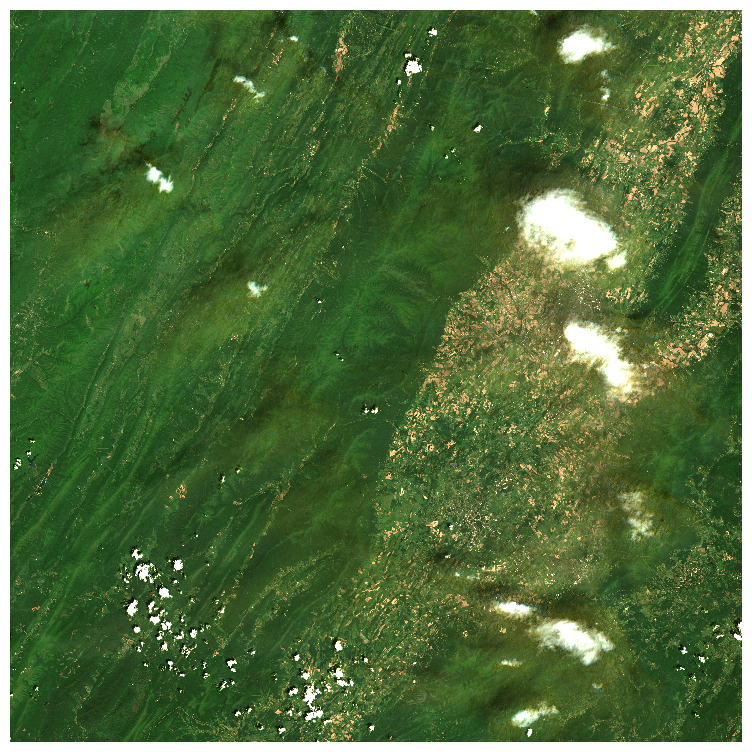

In [50]:

# Bands 2, 3, and 4 are B, G, and R in Sentinel-2 HLS images
composite_bands = [4,3,2]

urls = [sentinel_url.replace(sband,'_' + str(b).zfill(2)) for b in composite_bands]
print('Rendering URLs:')
for s in urls:
    print(s)

image_data = []

composite_downsample_factor = 5
composite_norm_value = 1500

for fn in urls:
    with rasterio.open(fn,'r') as raster:
        h = int(raster.height/composite_downsample_factor)
        w = int(raster.width/composite_downsample_factor)
        band_array = raster.read(1, out_shape=(1, h, w))
        raster.close()
        band_array = band_array / composite_norm_value
        image_data.append(band_array)

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)

dpi = 100; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)
plt.imshow(rgb);

In [55]:
image_data[0].shape

(732, 732)

In [51]:
i_daynum = int(daynum)
product = 'L30'

# Try days sequentially until we find one where there's a Landsat image for this day
while True:
    
    daynum = str(i_daynum).zfill(3)
    prefix = product + '/HLS.' + product + '.T' + tile_id + '.' + year + daynum
    print('Finding tiles with prefix {}'.format(prefix))
    matches = list_available_tiles(prefix)
    
    if len(matches) == 0:
        print('No matching tiles')
        i_daynum += 1
    else:
        break

blob_name = matches[0]
landsat_url = hls_blob_root + '/' + blob_name
print('Found {} matching tiles, e.g.:\n{}'.format(len(matches),landsat_url))

Finding tiles with prefix L30/HLS.L30.T17SPC.2020159
No matching tiles
Finding tiles with prefix L30/HLS.L30.T17SPC.2020160
No matching tiles
Finding tiles with prefix L30/HLS.L30.T17SPC.2020161
Found 11 matching tiles, e.g.:
https://hlssa.blob.core.windows.net/hls/L30/HLS.L30.T17SPC.2020161.v1.4_01.tif


Rendering URLs:
https://hlssa.blob.core.windows.net/hls/L30/HLS.L30.T17SPC.2020161.v1.4_04.tif
https://hlssa.blob.core.windows.net/hls/L30/HLS.L30.T17SPC.2020161.v1.4_03.tif
https://hlssa.blob.core.windows.net/hls/L30/HLS.L30.T17SPC.2020161.v1.4_02.tif


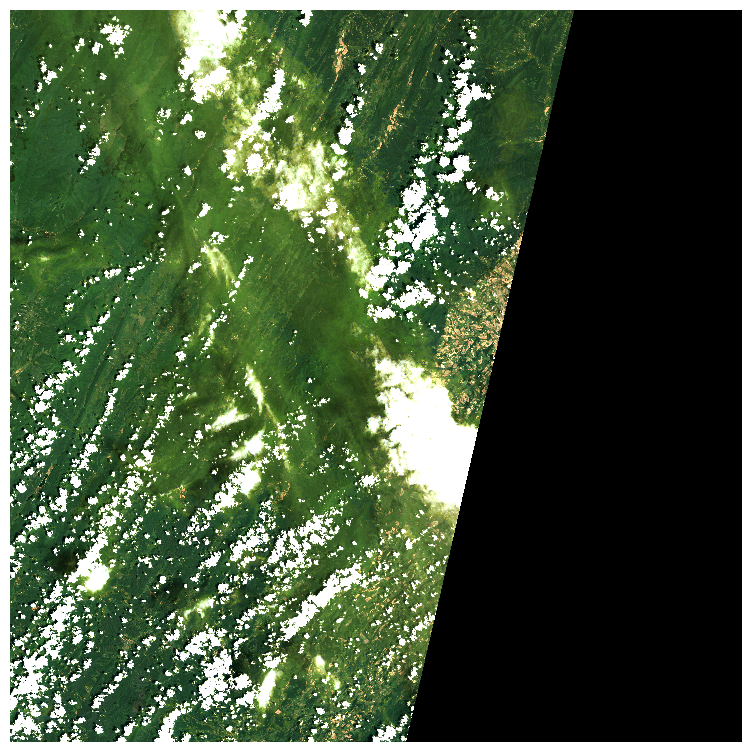

In [52]:
urls = [landsat_url.replace(sband,'_' + str(b).zfill(2)) for b in composite_bands]
print('Rendering URLs:')
for s in urls:
    print(s)

image_data = []
for fn in urls:
    with rasterio.open(fn,'r') as raster:
        h = int(raster.height/composite_downsample_factor)
        w = int(raster.width/composite_downsample_factor)
        band_array = raster.read(1, out_shape=(1, h, w))
        raster.close()
        band_array = band_array / composite_norm_value
        image_data.append(band_array)

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)

dpi = 100; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)
plt.imshow(rgb);